In [30]:
import sqlite3
import pandas as pd
import numpy as np
import os
import geopandas as gpd
import rasterio as rio
from rasterio.plot import show
from scripts.scripts import *

# Data preparation
From raw ROS2 bags, to usable pandas dataframes

In [31]:
#name of the ROSbag
rosbagname = "test9_April28"

# the bags are found in this zip under data
# directory should point to that

db_loc = os.path.join(os.path.expanduser('~'), "Documents","wqdrone","rosbags",rosbagname,rosbagname+"_0.db3")

#create connection to rosbag
con = sqlite3.connect(db_loc)

#read the topics in the rosbag
topics = pd.read_sql("SELECT * from topics", con)
# read all the msgs in the rosbag
msgs = pd.read_sql("SELECT * from messages", con)

#/topics that you want
t1 = "teensy_fix" 
t2 =  "wq_sensors"

#the above function is called to create df out of the rosbag
df_fix = parse_df(topics,msgs, t1,gps_float64,cols = ["lat", "lon","alt"])
df_wq = parse_df(topics,msgs, t2, wq_float64,cols = ["temp","tds","turb","t_v","ph","ph_v"])


#The data is merged to the closest neighbor, based on timestamp.
df = pd.merge_asof(df_fix,df_wq, on = "timestamp").dropna()
#create gdf to convert WGS84 to UTM
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat), crs = "EPSG:4326")

#select until row n
# n = 150
#df = df[df["timestamp"] < df["timestamp"][n]]

# Model accuracy

Let's run the interpolation with proper train/test splitting and accuracy measurements.


In [37]:
#making sure that every run will be the same
import random
random.seed("interpolation")

#Test-train splitting
msk = np.random.rand(len(df)) < 0.67
train = df[msk]
test = df[~msk]

#Run the interpolation model and save it as a raster
z,SS,gridx,gridy = interkrige(train.lon,
                              train.lat,
                              train.temp,
                              res = 100,
                             model = "linear")
#also add cutout mask phaps?
location = rasterbuilder(z,gridx,gridy, "train_temperature")

src = rio.open(location)



In [38]:
#create a geopandas df from the test-data
import geopandas as gpd
g_test = gpd.GeoDataFrame(test, geometry=gpd.points_from_xy(test.lon, test.lat), crs = "EPSG:4326")

#Sample the testing points from the dataset
coords = [(x,y) for x, y in zip(g_test.geometry.x, g_test.geometry.y)]
g_test['interpol_temp'] = [x[0] for x in src.sample(coords)]
# remove zeros from outside the box sampling
g_test = g_test[g_test['interpol_temp'] != 0]



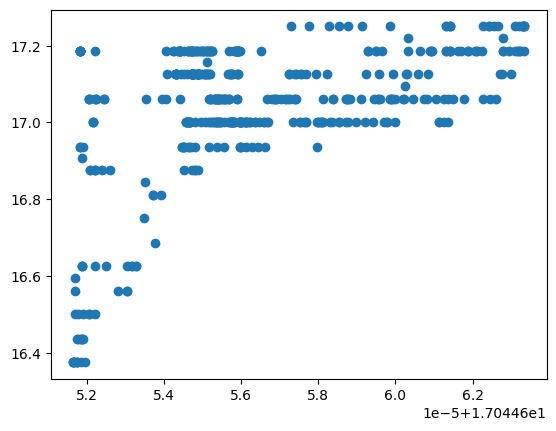

In [39]:
import matplotlib.pyplot as plt

plt.scatter(y = g_test.temp,x = g_test.interpol_temp)


<AxesSubplot:>

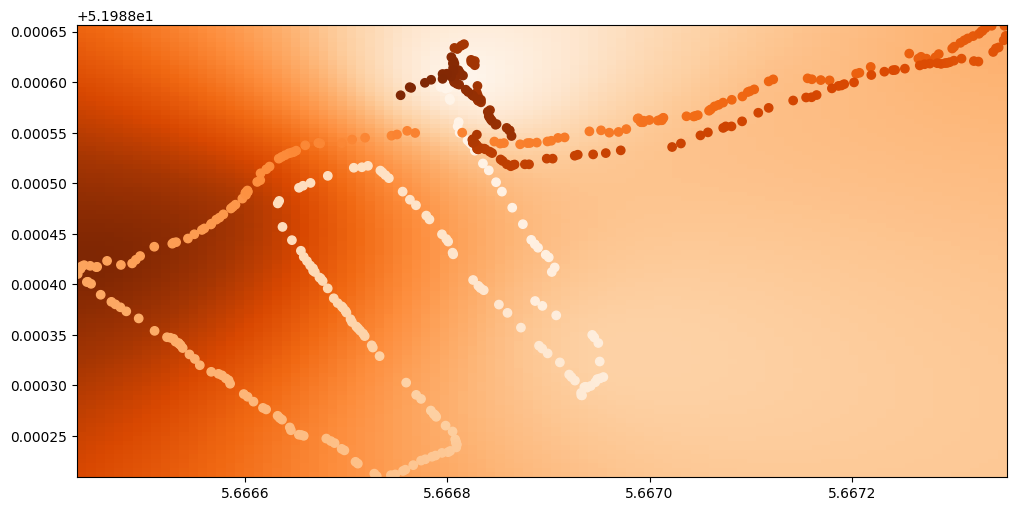

In [40]:
#visualize it all!
import matplotlib.pyplot as plt
from rasterio.plot import show
plt.style.use("default")
fig, ax = plt.subplots(figsize=(12,12))
g_test.plot(ax=ax, c= g_test["temp"], cmap = "Oranges")
show(src, ax=ax, cmap = "Oranges")